In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from time import time
from mtutil import SpectrogramNoteEventDataset
from mtconfig import SEED
from mtmodels import MultiEventMusicTranscriptionCNN
import matplotlib.pyplot as plt

# from basic_pitch.inference import predict, Model
# from basic_pitch import ICASSP_2022_MODEL_PATH


d:\Programming\Programs\Anaconda\envs\music_tran\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def predict_and_save_csv_multi_event(model, dataloader, device, output_csv_dir, n_events=10):
    model.eval()
    os.makedirs(output_csv_dir, exist_ok=True)

    predictions_per_audio = {}

    with torch.no_grad():
        for inputs, _, prefix, frame_start in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()

            for batch_index, output in enumerate(outputs):
                audio_prefix = prefix[batch_index]
                frame_start_time = frame_start[batch_index]

                if audio_prefix not in predictions_per_audio:
                    predictions_per_audio[audio_prefix] = []

                for i in range(n_events):
                    start_time, end_time, pitch, velocity, confidence = output[i]
                    if start_time >= end_time or confidence <= 0:
                        continue

                    predictions_per_audio[audio_prefix].append([
                        float(frame_start_time + start_time),
                        float(frame_start_time + end_time),
                        int(pitch),
                        min(max(float(velocity), 0), 127),
                        min(max(float(confidence), 0.0), 1.0)
                    ])

    # Save each prediction to a separate CSV file
    for audio_prefix, predictions in predictions_per_audio.items():
        df = pd.DataFrame(predictions, columns=["start_time", "end_time", "pitch", "velocity", "confidence"])
        df.to_csv(os.path.join(output_csv_dir, f"{audio_prefix}_predictions.csv"), index=False)

    print(f"Predictions saved to {output_csv_dir}")
# Training Functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, targets, _, _ in dataloader:
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, targets, _, _ in dataloader:
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

    return running_loss / len(dataloader)

In [6]:
X_dir = "../BasicPitchTCN_prediction/spectrograms"
y_dir = "../BasicPitchTCN_prediction/csv"
output_dir = "../CNN_Prediction_result/"

In [3]:
# Set random seed for reproducibility
torch.manual_seed(SEED)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

print("Loading dataset...")
dataset = SpectrogramNoteEventDataset(X_dir, y_dir, n_events=10, transform=transform)
print(f"Dataset loaded with {len(dataset)} samples")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = MultiEventMusicTranscriptionCNN(n_events=10).to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Loading dataset...
Dataset loaded with 69313 samples
Train size: 55450, Val size: 13863
Using device: cuda
MultiEventMusicTranscriptionCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [4]:
# Training Loop
train_losses = []
val_losses = []
epoches = []

num_epochs = 10
start_time = time()
for epoch in range(num_epochs):
    epoches.append(epoch)
    epoch_start_time = time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Time taken in thie epoch: {time() - epoch_start_time:.2f}s") 
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
print(f"Total time taken: {time() - start_time:.2f}s")

# Save the Model
model_path = "multi_event_music_transcription_cnn.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Time taken in thie epoch: 355.72s
Epoch 1/10, Train Loss: 79.5526, Val Loss: 64.0326
Time taken in thie epoch: 151.18s
Epoch 2/10, Train Loss: 60.6735, Val Loss: 58.9695
Time taken in thie epoch: 169.12s
Epoch 3/10, Train Loss: 56.3425, Val Loss: 53.5399
Time taken in thie epoch: 152.95s
Epoch 4/10, Train Loss: 53.4559, Val Loss: 52.3545
Time taken in thie epoch: 187.70s
Epoch 5/10, Train Loss: 51.2058, Val Loss: 50.9973
Time taken in thie epoch: 214.74s
Epoch 6/10, Train Loss: 49.7069, Val Loss: 49.8436
Time taken in thie epoch: 243.81s
Epoch 7/10, Train Loss: 48.5351, Val Loss: 51.6239
Time taken in thie epoch: 201.93s
Epoch 8/10, Train Loss: 47.5796, Val Loss: 52.5280
Time taken in thie epoch: 147.82s
Epoch 9/10, Train Loss: 46.9113, Val Loss: 46.8125
Time taken in thie epoch: 164.79s
Epoch 10/10, Train Loss: 45.8576, Val Loss: 46.4551
Total time taken: 1989.78s
Model saved to multi_event_music_transcription_cnn.pth


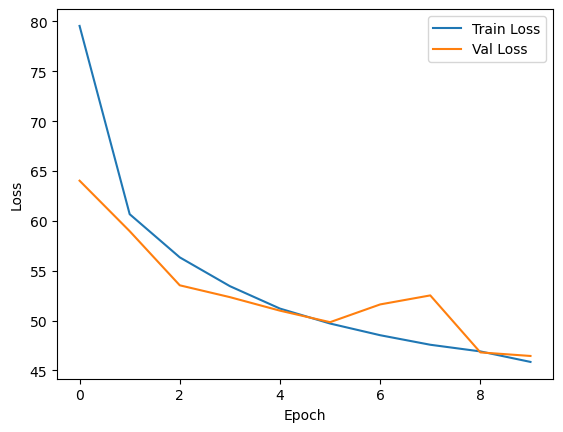

In [5]:
plt.plot(epoches, train_losses, label="Train Loss")
plt.plot(epoches, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Predict and Save Predictions as CSV
predict_and_save_csv_multi_event(model, val_loader, device, output_dir, n_events=10)

In [ ]:
#
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from torchvision import transforms
# import sys
# sys.path.append('../Preprocessor/')  # Add the directory, not the file
# from DatasetBuilding_Saving import SpectrogramNoteEventDataset  # Import class
# import pandas as pd
# # CNN Model Definition
# class MultiEventMusicTranscriptionCNN(nn.Module):
#     def __init__(self, n_events=10):
#         super(MultiEventMusicTranscriptionCNN, self).__init__()
#         self.n_events = n_events
#         self.output_size = n_events * 5
#
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(64 * 8 * 8, 128)
#         self.fc2 = nn.Linear(128, self.output_size)
#
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#
#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.maxpool(x)
#
#         x = self.relu(self.conv2(x))
#         x = self.maxpool(x)
#
#         x = self.relu(self.conv3(x))
#         x = self.maxpool(x)
#
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x.view(x.size(0), self.n_events, 5)
#
# # Function to load datasets
# def load_tensor_dataset(file_path):
#     data = torch.load(file_path)
#     return data
# # Function to predict and save CSV for multiple events
# def predict_and_save_csv_multi_event(model, dataloader, device, output_csv_dir, n_events=10):
#     model.eval()
#     predictions_per_audio = {}
#
#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs = inputs.to(device)
#             outputs = model(inputs).cpu().numpy()
#
#             for batch_index, output in enumerate(outputs):
#                 audio_prefix = targets[batch_index][0]  # Assuming first item in targets is the prefix
#                 frame_start_time = targets[batch_index][1]  # Assuming second item is frame start time
#
#                 if audio_prefix not in predictions_per_audio:
#                     predictions_per_audio[audio_prefix] = []
#
#                 for i in range(n_events):
#                     start_time, end_time, pitch, velocity, confidence = output[i]
#                     if start_time >= end_time or confidence <= 0:
#                         continue
#
#                     predictions_per_audio[audio_prefix].append([
#                         float(frame_start_time + start_time),
#                         float(frame_start_time + end_time),
#                         int(pitch),
#                         min(max(int(velocity), 0), 127),
#                         min(max(float(confidence), 0.0), 1.0)
#                     ])
#
#     # Save each prediction to a separate CSV file
#     for audio_prefix, predictions in predictions_per_audio.items():
#         df = pd.DataFrame(predictions, columns=["start_time", "end_time", "pitch", "velocity", "confidence"])
#         df.to_csv(os.path.join(output_csv_dir, f"{audio_prefix}_predictions.csv"), index=False)
#
#     print(f"Predictions saved to {output_csv_dir}")
#
#
# # Paths
# # Define the directory for data and output
# data_dir = '../READY_datasets'
# output_csv_dir = '../CNN_Prediction_result'
# os.makedirs(output_csv_dir, exist_ok=True)
#
# # Loading datasets
# train_dataset = load_tensor_dataset(os.path.join(data_dir, 'train_dataset.pth'))
# val_dataset = load_tensor_dataset(os.path.join(data_dir, 'val_dataset.pth'))
# test_dataset = load_tensor_dataset(os.path.join(data_dir, 'test_dataset.pth'))
#
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#
# # Setup device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
# # Model instantiation
# model = MultiEventMusicTranscriptionCNN(n_events=10).to(device)
#
# # Loss and Optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
#
# # Training Loop
# def train(model, dataloader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     for inputs, targets in dataloader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     return running_loss / len(dataloader)
#
# # Validation Loop
# def validate(model, dataloader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             running_loss += loss.item()
#     return running_loss / len(dataloader)
#
# num_epochs = 10
# for epoch in range(num_epochs):
#     train_loss = train(model, train_loader, criterion, optimizer, device)
#     val_loss = validate(model, val_loader, criterion, device)
#     print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
#
# # Save Model
# model_path = 'multi_event_music_transcription_cnn.pth'
# torch.save(model.state_dict(), model_path)
# print(f'Model saved to {model_path}')

